# Calculating the ***S***ecular ***H***eritability ***EST***imate (SHEST)



### Import Statements

In [1]:
import gspread
import os
import pylab
import math

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator
from google.colab import files
from scipy.optimize import curve_fit
from numpy.linalg import lstsq
from google.colab import drive

### Access Data

For information on how the csv files should be formatted, see the README.md file in https://github.com/relhajj/SHEST-heritability.

In [2]:
# mount google drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
# change directory to where the csvs are kept
# %cd /gdrive/Shared drives/SHEST Project/Data/csvs
%cd /gdrive/My Drive/SHEST Heritability/csvs

/gdrive/My Drive/SHEST Heritability/csvs


### Function Definitions

In [12]:
def fit_line(phenotype, header, ylabel, adj):
    # guide: fit_line(column name as found in dataframe,
    #                 graph title (phenotype name),
    #                 data description (e.g., Incidence / 100000),
    #                 y axis maximum adjustment to make graph look better)

    # get data
    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    eqn_slope = np.polyfit(xdata, ydata, 1)

    print("Min year:", int(min(xdata)))
    print("Max year:", int(max(xdata)), "\n")

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    print("Equation: %.3fx + %.3f"%(eqn_slope[0], eqn_slope[1]), "\n")

    print("H_min: %.3f" % min(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1]))
    print("H_max: %.3f" % max(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1]))

    print(header + " H^2: %.3f" % (min(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1])/max(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1])))
    print()

    ax = plt.figure(figsize=(8,5), edgecolor='black', facecolor='white').gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # for black figure border
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1.50

    plt.scatter(xdata, ydata, label='data', c='black', edgecolors='black')
    plt.title(header)
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.ylim(ymin=0, ymax=max(ydata)+adj)

    plt.plot(xdata, [x*eqn_slope[0]+eqn_slope[1] for x in xdata], color="black")
    plt.show()

    return eqn_slope

def fit_line_custom_start(phenotype, header, ylabel, adj, start):
    # guide: fit_line(column name as found in dataframe,
    #                 graph title (phenotype name),
    #                 data description (e.g., Incidence / 100000),
    #                 y axis maximum adjustment to make graph look better),
    #                 y axis start to make graph look better

    # get data
    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    eqn_slope = np.polyfit(xdata, ydata, 1)

    print("Min year:", int(min(xdata)))
    print("Max year:", int(max(xdata)), "\n")

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    print("Equation: %.3fx + %.3f"%(eqn_slope[0], eqn_slope[1]), "\n")

    print("H_min: %.3f" % min(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1]))
    print("H_max: %.3f" % max(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1]))

    print(header + " H^2: %.3f" % (min(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1])/max(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1])))
    print()

    ax = plt.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.scatter(xdata, ydata, label='data')
    plt.title(header)
    plt.xlabel("Year")
    plt.ylabel(header+" "+ylabel)

    # Figure border
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1.50

    plt.ylim(ymin=start, ymax=max(ydata)+adj)
    plt.plot(xdata, [x*eqn_slope[0]+eqn_slope[1] for x in xdata], color="black")

    #plt.savefig(header+'.png') #uncomment to save figure in google drive

    plt.show()

    return eqn_slope

def fit_test(phenotype):
    # guide: fit_line(column name as found in dataframe,
    #                 graph title (phenotype name),
    #                 data description (e.g., Incidence / 100000),
    #                 y axis maximum adjustment to make graph look better)

    # get data
    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    eqn_slope = np.polyfit(xdata, ydata, 1)

    ax = plt.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.scatter(xdata, ydata, c='black')
    plt.ylim(ymin=0, ymax=(max(ydata)+min(ydata)))

    #plt.savefig(header+'.png') #uncomment to save figure in google drive

    plt.show()

    return eqn_slope

def sigmoid(x, L ,x0, k, b):
    # Sigmoid Equation
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

def fit_sigmoid_example(phenotype, header, ylabel, adj):
    # guide: fit_sigmoid(column name as found in dataframe,
    #                    graph title (phenotype name),
    #                    data description (e.g., Incidence / 100000),
    #                    y axis maximum adjustment to make graph look better)

    # get data
    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    p0 = [max(ydata), np.median(xdata),1,min(ydata)]
    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')

    print("Min year:", int(min(xdata)))
    print("Max year:", int(max(xdata)), "\n")

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    print("Equation: %.3f / (1 + e^(-%.3f*(x - %.3f))) + %.3f" % (popt[0], popt[1], popt[2], popt[3]), "\n")

    print("H_min: %.3f" % min(popt[3], (popt[0]+popt[3])))
    print("H_max: %.3f" % max(popt[3], (popt[0]+popt[3])))

    print(header + " H^2: %.3f" % (min(popt[3]/(popt[0]+popt[3]),(popt[0]+popt[3])/popt[3])))
    print()

    x = np.linspace(min(xdata), max(xdata))
    y = sigmoid(x, *popt)

    ax = pylab.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # for black figure border
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1.50

    plt.title(header)
    pylab.xlabel("Year")

    pylab.ylabel(ylabel)
    plt.ylim(ymin=0, ymax=(max(ydata)+adj))

    pylab.plot(xdata, ydata, 'o', color='black')
    pylab.plot(x, y, color='black')

    xmin = min(xdata)
    xmax = max(xdata)
    ymax= max(ydata)+adj
    ax.axis([xmin, xmax, 0, ymax])
    ax.text(0, 10, r'Minimum', fontsize=15)

    #plt.savefig(header+'.png') #uncomment to save figure in google drive

    pylab.show()

    return popt

def fit_sigmoid(phenotype, header, ylabel, adj):
    # guide: fit_sigmoid(column name as found in dataframe,
    #                    graph title (phenotype name),
    #                    data description (e.g., Incidence / 100000),
    #                    y axis maximum adjustment to make graph look better)

    # get data
    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    p0 = [max(ydata), np.median(xdata),1,min(ydata)]
    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')

    print("Min year:", int(min(xdata)))
    print("Max year:", int(max(xdata)), "\n")

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    print("Equation: %.3f / (1 + e^(-%.3f*(x - %.3f))) + %.3f" % (popt[0], popt[1], popt[2], popt[3]), "\n")

    print("H_min: %.3f" % min(popt[3], (popt[0]+popt[3])))
    print("H_max: %.3f" % max(popt[3], (popt[0]+popt[3])))

    print(header + " H^2: %.3f" % (min(popt[3]/(popt[0]+popt[3]),(popt[0]+popt[3])/popt[3])))
    print()

    x = np.linspace(min(xdata), max(xdata))
    y = sigmoid(x, *popt)

    ax = pylab.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # for black figure border
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1.50

    plt.title(header)
    pylab.xlabel("Year")

    pylab.ylabel(ylabel)

    plt.ylim(ymin=0, ymax=(max(ydata)+adj))

    pylab.plot(xdata, ydata, 'o', color='black')
    pylab.plot(x, y, color='black')

    #plt.savefig(header+'.png') #uncomment to save figure in google drive

    pylab.show()

    return popt

ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

def SegmentedLinearReg( X, Y, breakpoints ):
    nIterationMax = 10

    breakpoints = np.sort( np.array(breakpoints) )

    dt = np.min( np.diff(X) )
    ones = np.ones_like(X)

    for i in range( nIterationMax ):
        # Linear regression:  solve A*p = Y
        Rk = [ramp( X - xk ) for xk in breakpoints ]
        Sk = [step( X - xk ) for xk in breakpoints ]
        A = np.array([ ones, X ] + Rk + Sk )
        p =  lstsq(A.transpose(), Y, rcond=None)[0]

        # Parameters identification:
        a, b = p[0:2]
        ck = p[ 2:2+len(breakpoints) ]
        dk = p[ 2+len(breakpoints): ]

        # Estimation of the next break-points:
        newBreakpoints = breakpoints - dk/ck

        # Stop condition
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            break

        breakpoints = newBreakpoints
    else:
        print( 'maximum iteration reached' )

    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones =  np.ones_like(Xsolution)
    Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )

    #plt.savefig(header+'.png') #uncomment to save figure in google drive

    return Xsolution, Ysolution

def fit_segmented(phenotype, header, ylabel, adj, initialBreakpoints):
    # guide: fit_segmented(column name as found in dataframe,
    #                      graph title (phenotype name),
    #                      data description (e.g., Incidence / 100000),
    #                      y axis maximum adjustment to make graph look better,
    #                      list of years where the data seems to change)

    # get data

    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    x_sol, y_sol = SegmentedLinearReg(xdata, ydata, initialBreakpoints)

    print("Min year:", int(min(xdata)))
    print("Max year:", int(max(xdata)), "\n")

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    min_y_sol = min(y_sol)
    if min_y_sol < 0.0:
      min_y_sol = 0.0

    print("H_min: %.3f" % min_y_sol)
    print("H_max: %.3f" % max(y_sol))

    print(header + " H^2: %.3f" % (min_y_sol/max(y_sol)))
    print()

    ax = plt.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.plot(xdata, ydata, 'o', color='black')
    plt.xlabel("Year")
    plt.ylabel(ylabel)

    # Figure border
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1.50

    plt.title(header)
    plt.ylim(ymin=0, ymax=(max(ydata)+min(ydata)+adj))
    plt.plot( *SegmentedLinearReg(xdata, ydata, initialBreakpoints ), '-', color="black")

    #plt.savefig(header+'.png') #uncomment to save figure in google drive

    return SegmentedLinearReg(xdata, ydata, initialBreakpoints)

def minmax_time(phenotype, header, ylabel, xlabel, adj):
    # guide: minmax_time(column name as found in dataframe,
    #                    graph title (phenotype name),
    #                    y-axis data description (e.g., Incidence / 100000),
    #                    x-axis data description (e.g., Year),
    #                    y axis maximum adjustment to make graph look better)

    xdata = [i for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    if min(xdata).isdigit() and max(xdata).isdigit():
      print("Min year:", int(min(xdata)))
      print("Max year:", int(max(xdata)), "\n")
    else:
      print("Min year:", min(xdata))
      print("Max year:", max(xdata), "\n")

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    print(header + " H^2: %.3f" % (min(ydata)/max(ydata)))
    print()

    fig, ax = plt.subplots(figsize=(8,5))
    plt.bar(xdata, ydata)

    for i, v in enumerate(ydata):
        ax.text(i - len(xdata)*(0.02), v + 0.02*max(ydata), str(round(v,2)), color='black')

    plt.title(header)
    plt.xlabel(xlabel)
    plt.ylabel(header+" "+ylabel)

    plt.ylim(ymin=0, ymax=(max(ydata)+min(ydata)+adj))

    #plt.savefig(header+'.png')
    # files.download('test.png')

    plt.show()

def scatter(phenotype, header, ylabel, adj):
    # guide: scatter(column name as found in dataframe,
    #                graph title (phenotype name),
    #                y-axis data description (e.g., Incidence / 100000),
    #                y axis maximum adjustment to make graph look better)

    # get data
    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    print("Min year:", int(min(xdata)))
    print("Max year:", int(max(xdata)), "\n")

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    print(header + " H^2: %.3f" % (min(ydata)/max(ydata)))
    print()

    ax = plt.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.scatter(xdata, ydata, label='data', c='black')
    plt.plot(xdata, ydata, label='data', c='black')
    plt.title(header)
    plt.xlabel("Year")

    # Figure border
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1.50

    plt.ylabel(ylabel)
    plt.ylim(ymin=0, ymax=(max(ydata)+min(ydata)+adj))

    #plt.savefig(header+'.png')

    plt.show()

def scatter_date_xaxis(phenotype, header, ylabel, adj):
    # guide: scatter(column name as found in dataframe,
    #                graph title (phenotype name),
    #                y-axis data description (e.g., Incidence / 100000),
    #                y axis maximum adjustment to make graph look better)

    # get data
    xdata = [i for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    print(header + " H^2: %.3f" % (min(ydata)/max(ydata)))
    print()

    ax = plt.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.scatter(xdata, ydata, label='data', c='black')
    plt.plot(xdata, ydata, label='data', c='black')
    plt.title(header)
    plt.xlabel("Date")

    # Figure border
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1.50

    plt.ylabel(ylabel)
    plt.ylim(ymin=-20, ymax=(max(ydata)+min(ydata)+adj))

    #plt.savefig(header+'.png')

    plt.show()

def scatter_quantitative(phenotype, header, ylabel, adj, SD, y_start):
    # guide: scatter(column name as found in dataframe,
    #                graph title (phenotype name),
    #                y-axis data description (e.g., Incidence / 100000),
    #                y axis maximum adjustment to make graph look better
    #                Standard deviation used to report Quantitative SHEST H2 estimate
    #                Custome starting point of Y axis to make graph look better

    # get data
    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    # if SD not provided, calculate it (use for SBP and DBP)
    if SD == None:
      # std() calculates population SD
      SD = np.array(ydata).std()

    E = (max(ydata) - min(ydata))/(4*SD)
    quantitative_SHEST = 1-E

    print("Min year:", int(min(xdata)))
    print("Max year:", int(max(xdata)), "\n")

    print("Min Inc/Prev: %.5f" % min(ydata))
    print("Max Inc/Prev: %.5f" % max(ydata), "\n")

    print("Standard Deviation: %.2f" % SD, "\n")

    print("G = 1 - E = 1 - %.5f" % E, "\n")

    print(header + " H^2: %.5f" % quantitative_SHEST)
    print()

    ax = plt.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.scatter(xdata, ydata, label='data', c='black')
    plt.plot(xdata, ydata, label='data', c='black')
    plt.title(header)
    plt.xlabel("Year")

    # Figure border
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1.50

    plt.ylabel(ylabel)
    plt.ylim(ymin=y_start, ymax=(max(ydata)+adj))

    #plt.savefig(header+'.png') #uncomment to save figure in google drive
    #files.download(header+'.png') #uncomment to save figure on local machine

    plt.show()


### Create dataframe with all the conditions

In [ ]:
df = pd.DataFrame(data=[])

for filename in sorted(os.listdir(".")):
  print(filename)
  df_inc = pd.read_csv(filename, index_col=0)
  df_inc = df_inc[~df_inc.index.duplicated()]
  # print(df_inc.index.duplicated().any()) # uncomment this line to check for duplications
  df = df.merge(df_inc, how='outer', left_index=True, right_index=True)

### Accessing data sources

In [8]:
df.loc["source","type_I_diabetes_2"]

'https://www.researchgate.net/figure/Generalised-additive-model-for-time-trend-of-type-1-diabetes-mellitus-incidence_fig3_49690424'

### Calculate SHEST coefficient for different diseases, conditions and phenotypes

To calculate a SHEST coefficient, simply call the relevant function. The possible functions to call are:

*   fit_line()
*   fit_sigmoid()
*   fit_seqmented()
*   scatter()

For examples of how to call each function, see below.



#### Linear Regression Analysis

Min year: 1981
Max year: 2018 

Min Inc/Prev: 0.857
Max Inc/Prev: 1.000 

Equation: 0.000x + 0.769 

H_min: 0.972
H_max: 0.976
Black Hair Versus Non-black Hair H^2: 0.996



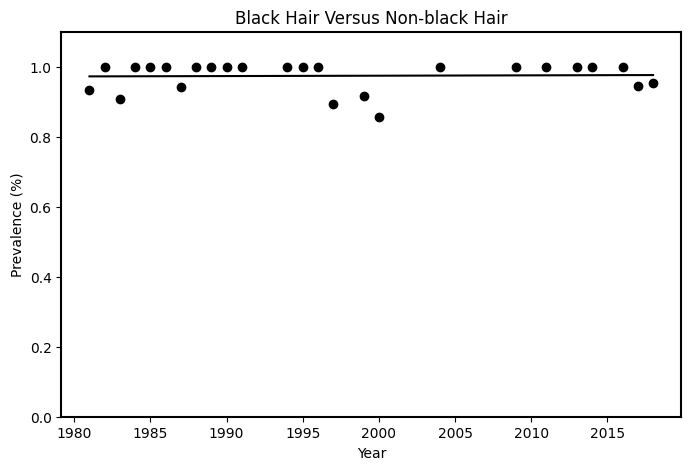

In [ ]:
eqn = fit_line("black_hair", "Black Hair Versus Non-black Hair", "Prevalence (%)", 0.1)

### Sigmoidal Model Analysis

Min year: 1975
Max year: 2016 

Min Inc/Prev: 5.197
Max Inc/Prev: 83.308 

Equation: 73.913 / (1 + e^(-1991.411*(x - 0.248))) + 4.659 

H_min: 4.659
H_max: 78.572
Breast Cancer H^2: 0.059



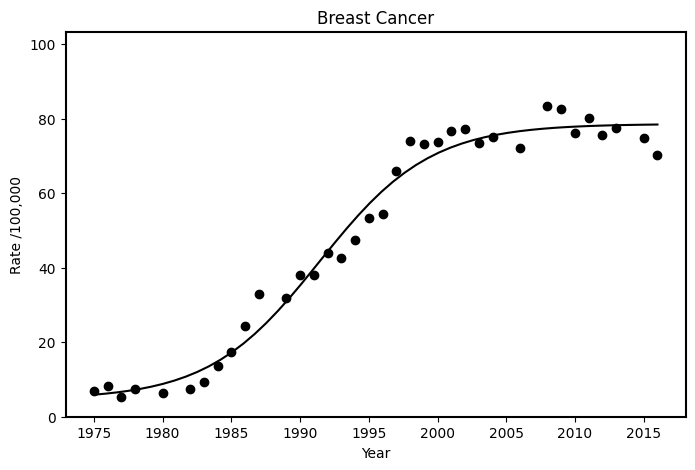

In [22]:
eqn = fit_sigmoid("brC", "Breast Cancer", "Rate /100,000", 20)

#### Segmented-Linear Regression Analysis

Min year: 1966
Max year: 2003 

Min Inc/Prev: 0.144
Max Inc/Prev: 1.470 

H_min: 0.158
H_max: 1.383
Atopic Dermatitis H^2: 0.114



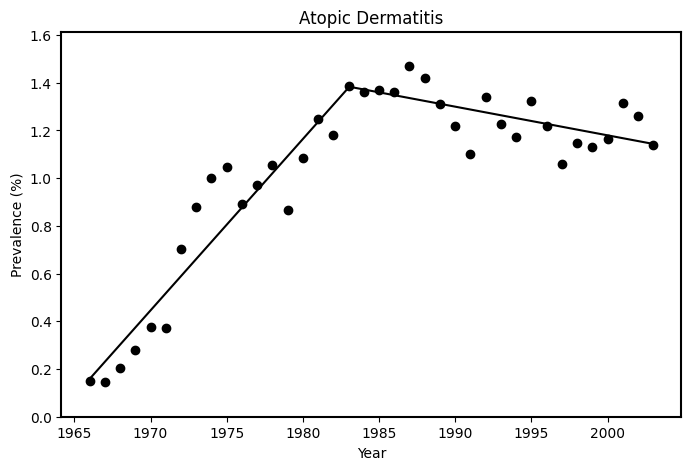

In [ ]:
eqn = fit_segmented("atopic_dermatitis", "Atopic Dermatitis", "Prevalence (%)", 0, [1982])

#### Raw Min/Max Calculation and Scatter Plot

Min year: 1950
Max year: 2020 

Min Inc/Prev: 0.000
Max Inc/Prev: 5384.000 

Poliomyelitis H^2: 0.000



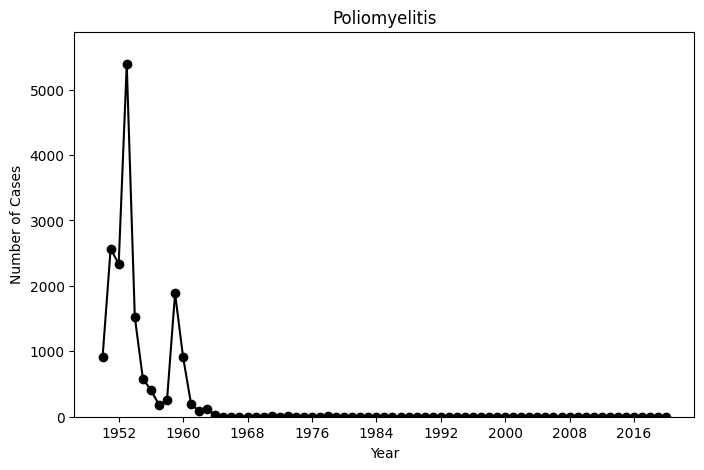

In [9]:
eqn = scatter("poliomyelitis", "Poliomyelitis", "Number of Cases", 500)

# Calculations used in our paper

The following cells of code below are the exact function calls used to estimate the SHEST Heritability estimates reported in our manuscript "A Novel Approach to Estimate Heritability". Please refer to our manuscript and supporting information for specific information on our method and data selection process.


## Manucript Figures

In [ ]:
# --- FIGURE 1
#fit_line("cf", "Linear Model", "Incidence", 10)
#fit_sigmoid("left_handedness_uk", "Sigmoidal Model", "Incidence", 2)
#fit_segmented("atopic_dermatitis", "Segmented Model", "Incidence", 0, [1982])

# --- FIGURE 2
#fit_segmented("atopic_dermatitis", "Atopic Dermatitis", "Prevalence (%)", 0, [1982])
#fit_line("cf", "Cystic Fibrosis", "Incidence /100,000", 10)
#scatter("poliomyelitis", "Poliomyelitis", "Number of Cases", 500)

# --- FIGURE 3
#fit_sigmoid_example("left_handedness_uk", "Sigmoidal Model", "Incidence", 2)
#fit_sigmoid("left_handedness_uk", "Sigmoidal Model", "Incidence", 2)

## Table 1: Genetic

Min year: 1981
Max year: 2018 

Min Inc/Prev: 0.857
Max Inc/Prev: 1.000 

Equation: 0.000x + 0.769 

H_min: 0.972
H_max: 0.976
Black Hair Versus Non-black Hair H^2: 0.996



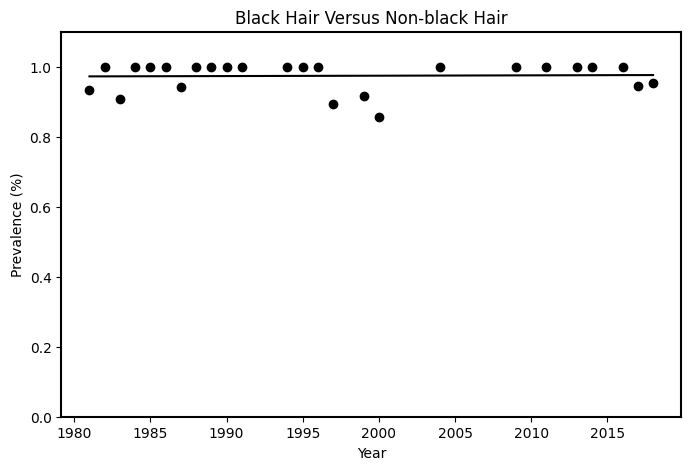

Min year: 1981
Max year: 2018 

Min Inc/Prev: 100.000
Max Inc/Prev: 100.000 

Equation: -0.000x + 100.000 

H_min: 100.000
H_max: 100.000
Brown Eyes Versus Non-brown Eyes H^2: 1.000



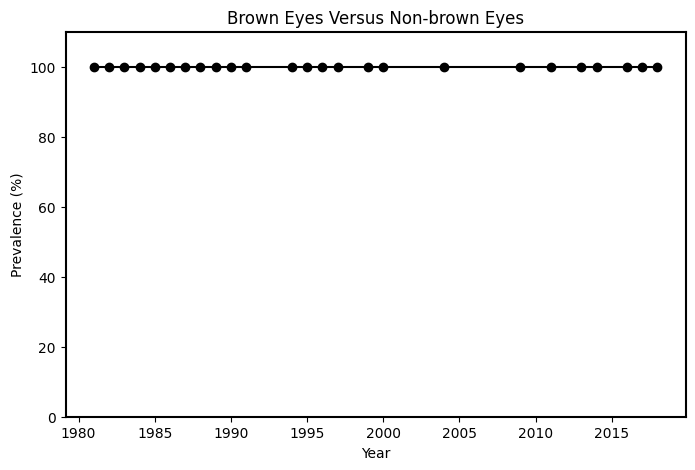

Min year: 1996
Max year: 2016 

Min Inc/Prev: 2904.407
Max Inc/Prev: 4296.155 

Equation: -0.592x + 4659.329 

H_min: 3465.422
H_max: 3477.266
Cystic Fibrosis H^2: 0.997



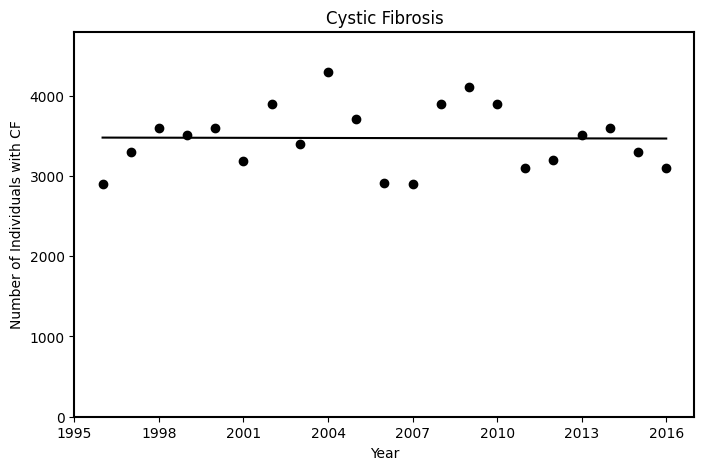

Min year: 2005
Max year: 2013 

Min Inc/Prev: 12.300
Max Inc/Prev: 14.600 

Equation: 0.128x + -244.355 

H_min: 12.953
H_max: 13.980
Down Syndrome H^2: 0.927



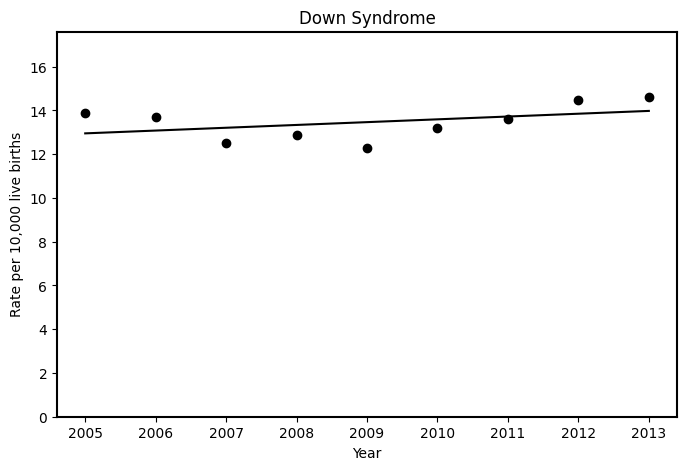

Min year: 1951
Max year: 1971 

Min Inc/Prev: 0.445
Max Inc/Prev: 0.540 

Equation: 0.001x + -2.223 

H_min: 0.470
H_max: 0.497
Hereditary Heamochromatosis H^2: 0.945



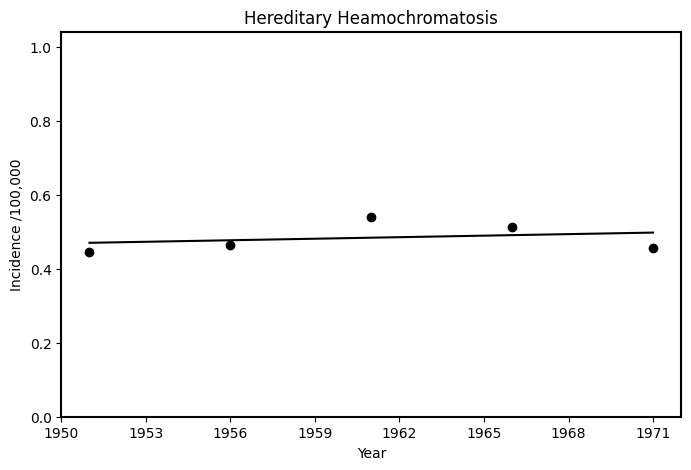

Min year: 1986
Max year: 2020 

Min Inc/Prev: 34846.000
Max Inc/Prev: 47621.000 

Equation: -50.182x + 141670.424 

H_min: 40302.071
H_max: 42008.271
Sex (Female) H^2: 0.959



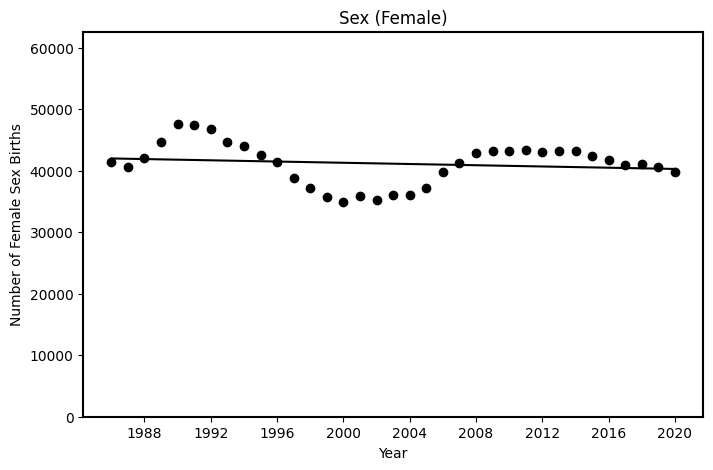

Min year: 1986
Max year: 2020 

Min Inc/Prev: 37164.000
Max Inc/Prev: 50392.000 

Equation: -52.288x + 148086.746 

H_min: 42465.076
H_max: 44242.867
Sex (Male) H^2: 0.960



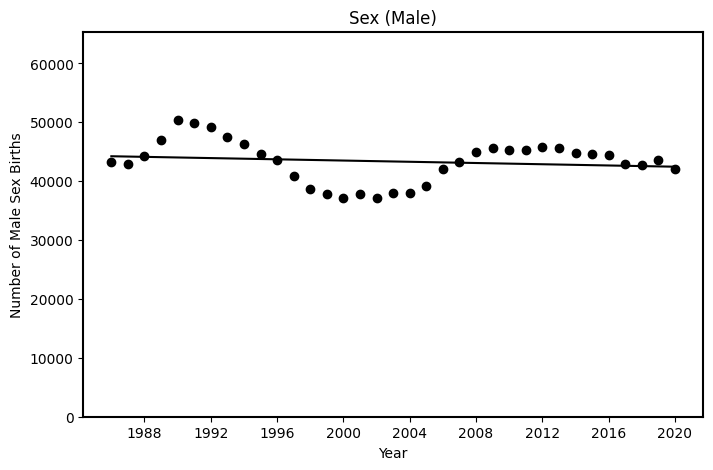

Min year: 1986
Max year: 2018 

Min Inc/Prev: 103.300
Max Inc/Prev: 106.700 

Equation: -0.010x + 126.021 

H_min: 105.113
H_max: 105.445
Sex Ratio H^2: 0.997



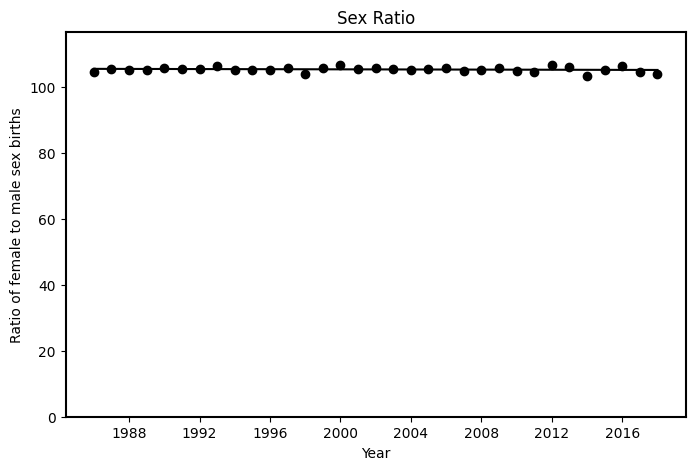

Min year: 1991
Max year: 2010 

Min Inc/Prev: 0.026
Max Inc/Prev: 0.050 

Equation: 0.000x + -0.128 

H_min: 0.034
H_max: 0.035
Sickle Cell Disease H^2: 0.956



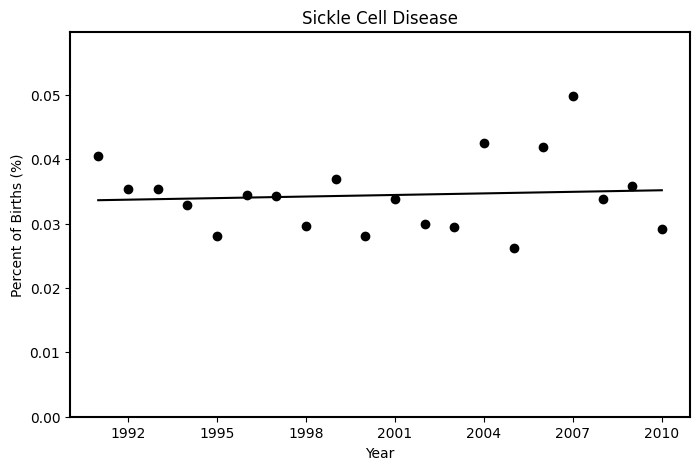

In [54]:
# Black hair
eqn = fit_line("black_hair", "Black Hair Versus Non-black Hair", "Prevalence (%)", 0.1)

# Brown eyes
eqn = fit_line("brown_eyes", "Brown Eyes Versus Non-brown Eyes", "Prevalence (%)", 10)

# CF
eqn = fit_line("cf", "Cystic Fibrosis", "Number of Individuals with CF", 500)

# Down syndrome
eqn = fit_line("down_syndrome", "Down Syndrome", "Rate per 10,000 live births", 3)

# Hereditary heamochromatosis
eqn = fit_line("g_Hereditary_Heam", "Hereditary Heamochromatosis", "Incidence /100,000", 0.5)

# Sex - female
eqn = fit_line("sexF", "Sex (Female)", "Number of Female Sex Births", 15000)

# Sex - male
eqn = fit_line("sexM", "Sex (Male)", "Number of Male Sex Births", 15000)

# Sex - ratio
eqn = fit_line("sex_ratio", "Sex Ratio", "Ratio of female to male sex births", 10)

# SCD
eqn = fit_line("scd", "Sickle Cell Disease", "Percent of Births (%)", 0.01)

## Table 2: Environmental

Min Inc/Prev: 0.000
Max Inc/Prev: 914.676 

COVID-19 H^2: 0.000



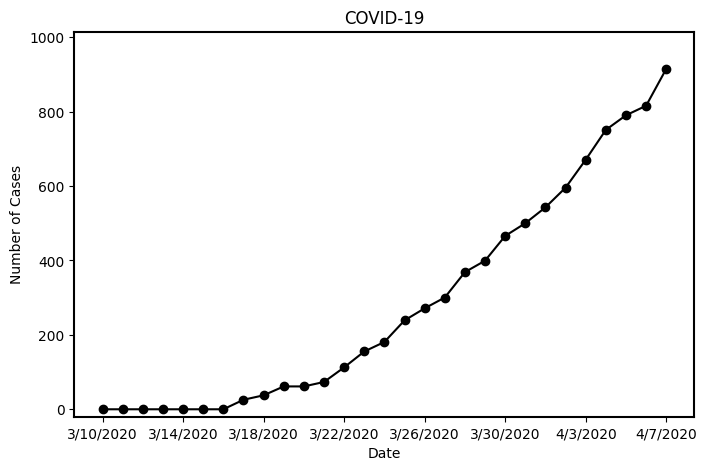

Min year: 1990
Max year: 2019 

Min Inc/Prev: 0.000
Max Inc/Prev: 39703.000 

Diphtheria H^2: 0.000



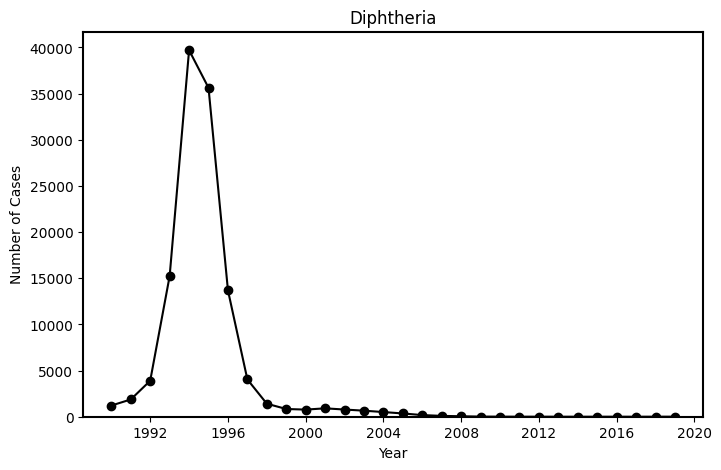

Min year: 1975
Max year: 2018 

Min Inc/Prev: 0.000
Max Inc/Prev: 5147.287 

Human Immunodeficiency Virus (HIV) H^2: 0.000



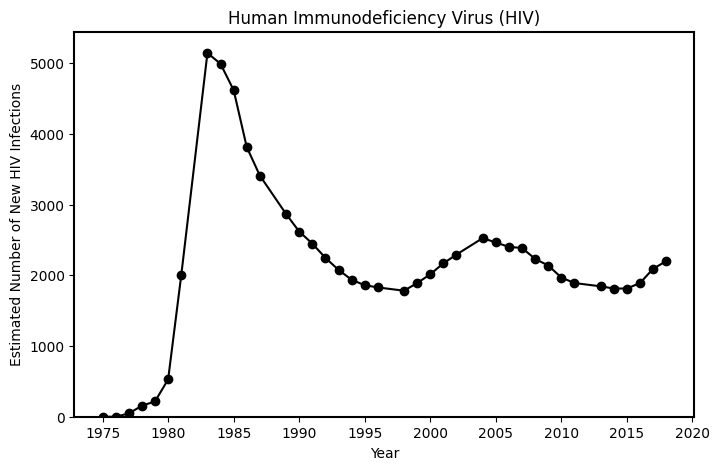

Min year: 1980
Max year: 2019 

Min Inc/Prev: 0.000
Max Inc/Prev: 162686.000 

Red Measles H^2: 0.000



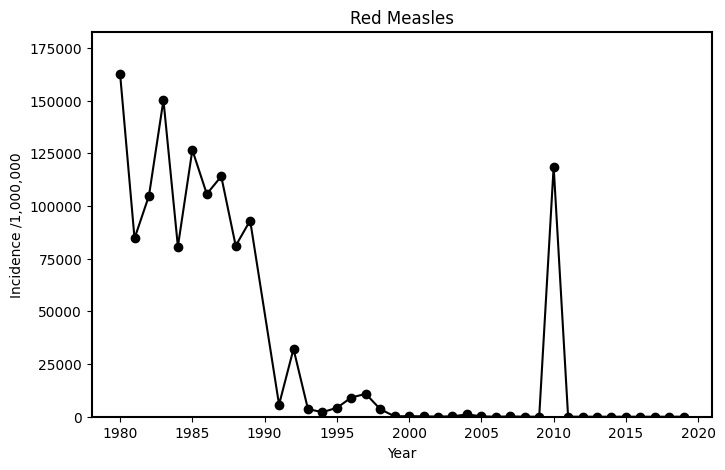

maximum iteration reached
Min year: 1900
Max year: 2012 

Min Inc/Prev: 0.000
Max Inc/Prev: 28.921 

H_min: 0.000
H_max: 29.264
Motor Vehicle Deaths H^2: 0.000

maximum iteration reached
maximum iteration reached
Min year: 1980
Max year: 2009 

Min Inc/Prev: 0.000
Max Inc/Prev: 6.408 

Syphilis H^2: 0.000



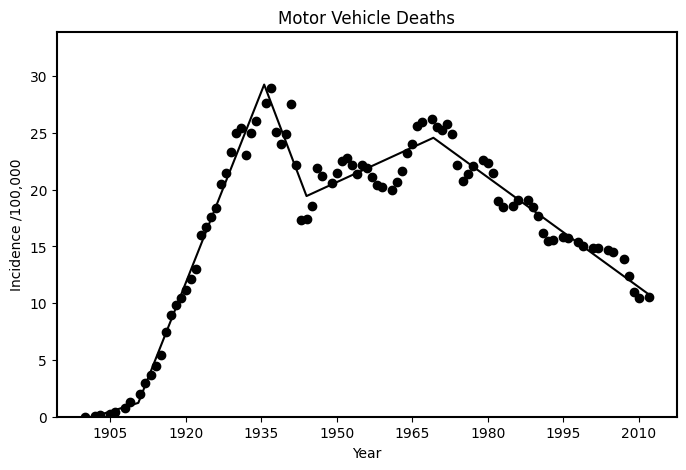

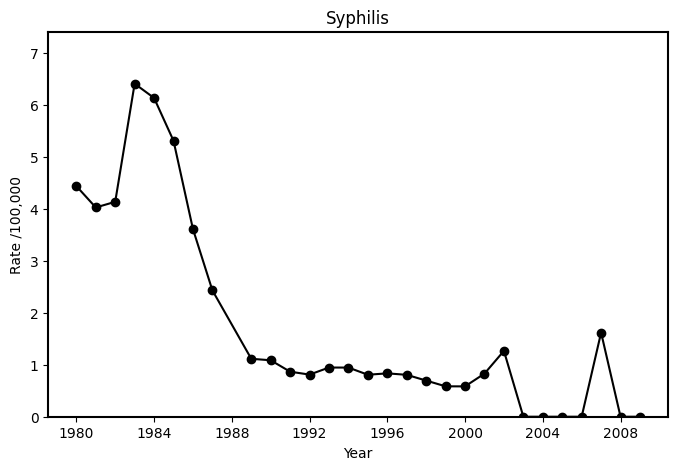

Min year: 1990
Max year: 2014 

Min Inc/Prev: 4.309
Max Inc/Prev: 409.954 

H_min: 0.000
H_max: 449.318
Varicella H^2: 0.000



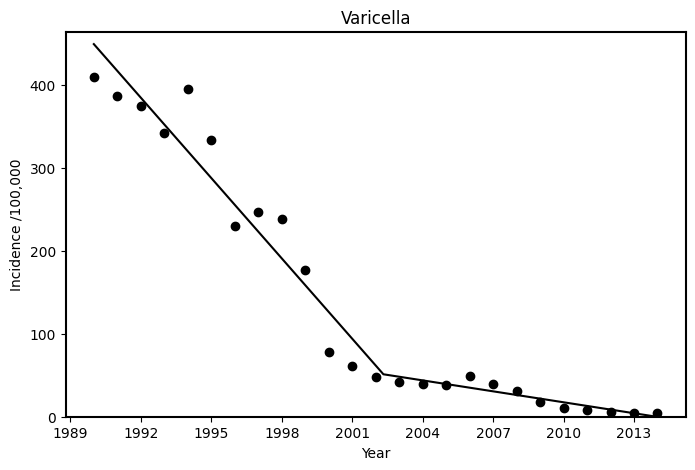

In [57]:
# COVID 19
eqn = scatter_date_xaxis("covid", "COVID-19", "Number of Cases", 100)

# Diphtheria
eqn = scatter("diph", "Diphtheria", "Number of Cases", 2000)

# HIV
eqn = scatter("hiv_can", "Human Immunodeficiency Virus (HIV)", "Estimated Number of New HIV Infections", 300)

# Measles
eqn = scatter("measles", "Red Measles", "Incidence /1,000,000", 20000)

# Motor vehicle deaths
eqn = fit_segmented("motor_deaths", "Motor Vehicle Deaths", "Incidence /100,000", 5, [1910,1940,1950,1970])

# Syphilis
eqn = scatter("syph", "Syphilis", "Rate /100,000", 1)

# Varicella
eqn = fit_segmented("varc", "Varicella", "Incidence /100,000", 50, [2001])

## Table 3: Environmental

Min year: 1996
Max year: 2017 

Min Inc/Prev: 94.000
Max Inc/Prev: 43378.000 

Mumps H^2: 0.002



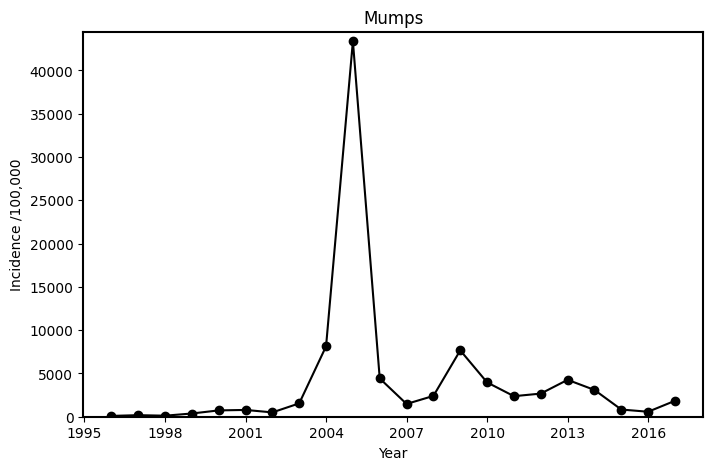

Min year: 1992
Max year: 2015 

Min Inc/Prev: 0.447
Max Inc/Prev: 4.024 

Peptic Ulcers H^2: 0.111



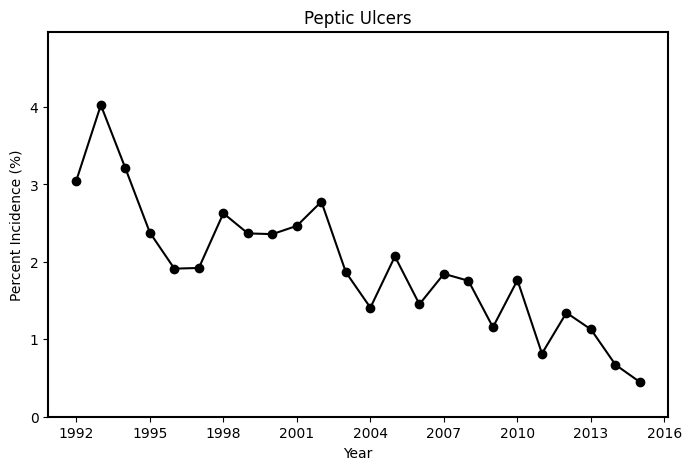

Min year: 1950
Max year: 2012 

Min Inc/Prev: 0.000
Max Inc/Prev: 5348.416 

Poliomyelitis H^2: 0.000



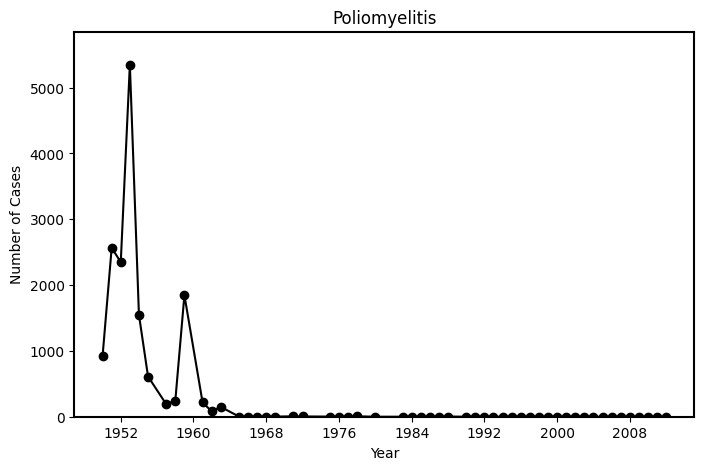

Min year: 2001
Max year: 2014 

Min Inc/Prev: 0.708
Max Inc/Prev: 548.724 

Rubella H^2: 0.001



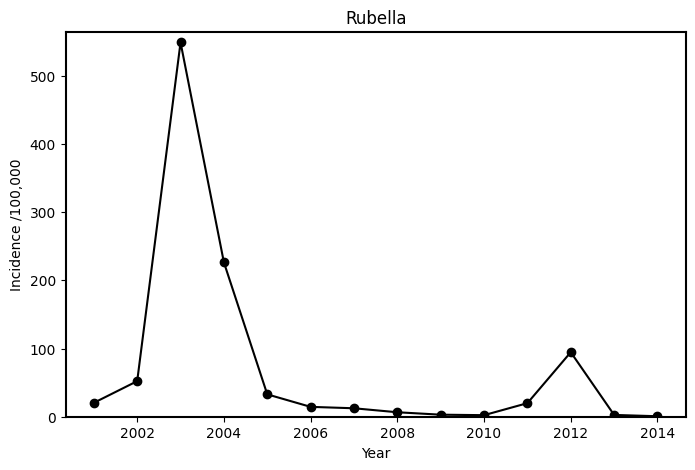

Min year: 1924
Max year: 2010 

Min Inc/Prev: 4.543
Max Inc/Prev: 103.697 

H_min: 1.900
H_max: 105.401
Tuberculosis H^2: 0.018



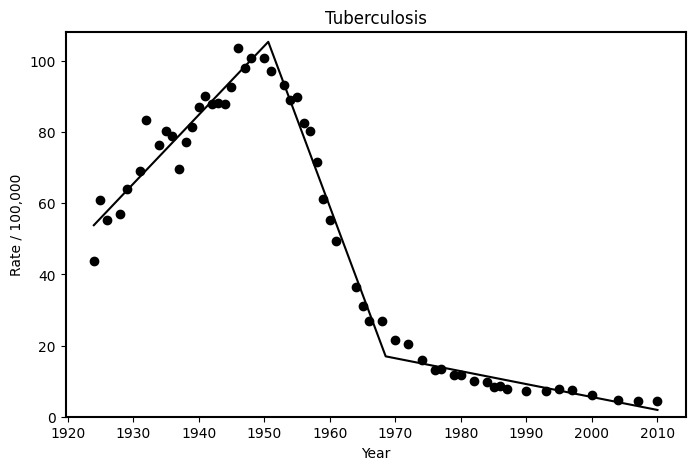

In [58]:
# Mumps
eqn = scatter("mumps", "Mumps", "Incidence /100,000", 1000)

# Peptic ulcers
eqn = scatter("peptic_ulcer", "Peptic Ulcers", "Percent Incidence (%)", 0.5)

# Poliomyelitis
eqn = scatter("polio", "Poliomyelitis", "Number of Cases", 500)

# Rubella
eqn = scatter("rubella", "Rubella", "Incidence /100,000", 15)

# Tuberculosis
eqn = fit_segmented("TB_canada", "Tuberculosis", "Rate / 100,000", 0, [1950, 1985])

## Table 4: Complex

Min year: 1985
Max year: 2005 

Min Inc/Prev: 1.100
Max Inc/Prev: 3.800 

Alzheimer's Disease H^2: 0.289



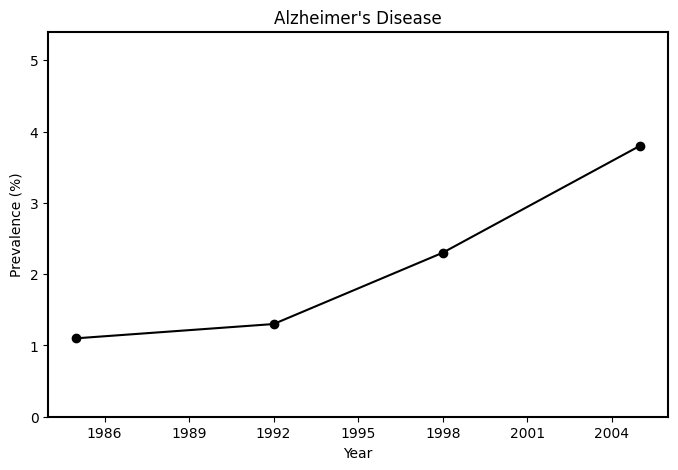

Min year: 1956
Max year: 1993 

Min Inc/Prev: 3.990
Max Inc/Prev: 19.720 

Equation: 0.434x + -843.384 

H_min: 5.103
H_max: 21.153
Anorexia Nervosa H^2: 0.241



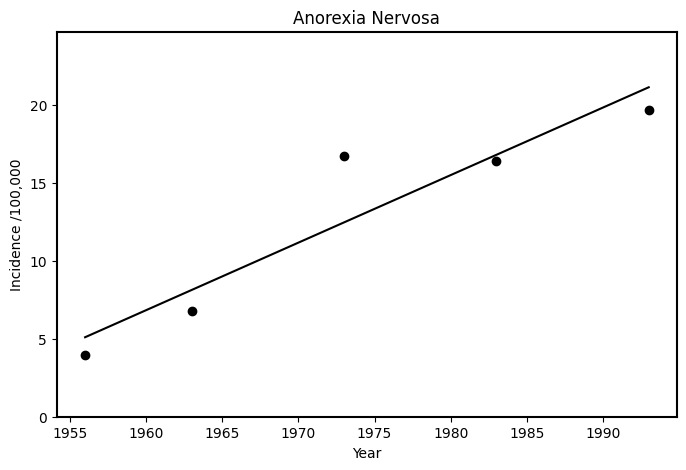

maximum iteration reached
Min year: 1967
Max year: 2003 

Min Inc/Prev: 0.305
Max Inc/Prev: 3.453 

H_min: 0.312
H_max: 3.538
Asthma H^2: 0.088

maximum iteration reached
maximum iteration reached
Min year: 1966
Max year: 2003 

Min Inc/Prev: 0.144
Max Inc/Prev: 1.470 

H_min: 0.158
H_max: 1.381
Atopic Dermatitis H^2: 0.115

Min year: 1931
Max year: 2014 

Min Inc/Prev: 0.000
Max Inc/Prev: 1.175 

H_min: 0.000
H_max: 1.148
Autism Spectrum Disorder H^2: 0.000

Min year: 1995
Max year: 2012 

Min Inc/Prev: 6.600
Max Inc/Prev: 40.530 

H_min: 6.533
H_max: 40.492
Bipolar Disorder H^2: 0.161

Min year: 1975
Max year: 2016 

Min Inc/Prev: 5.197
Max Inc/Prev: 83.308 

Equation: 73.913 / (1 + e^(-1991.411*(x - 0.248))) + 4.659 

H_min: 4.659
H_max: 78.572
Breast Cancer H^2: 0.059



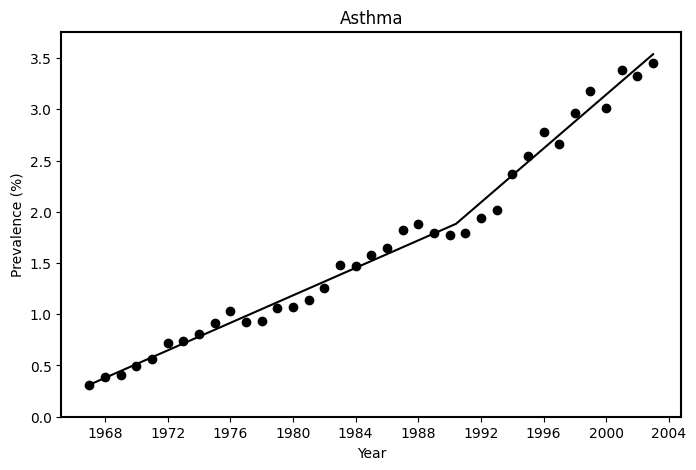

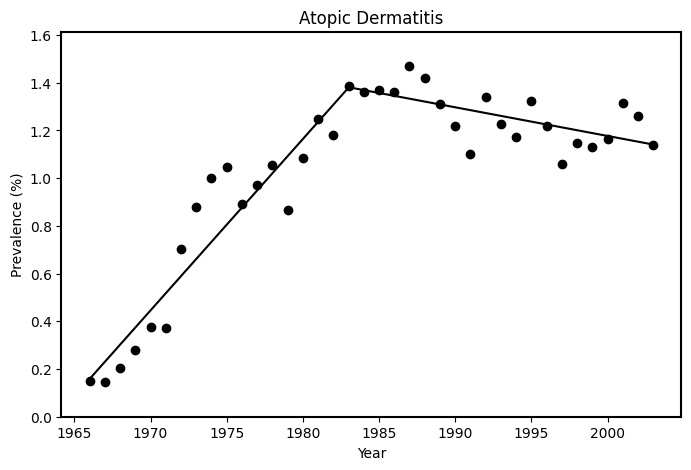

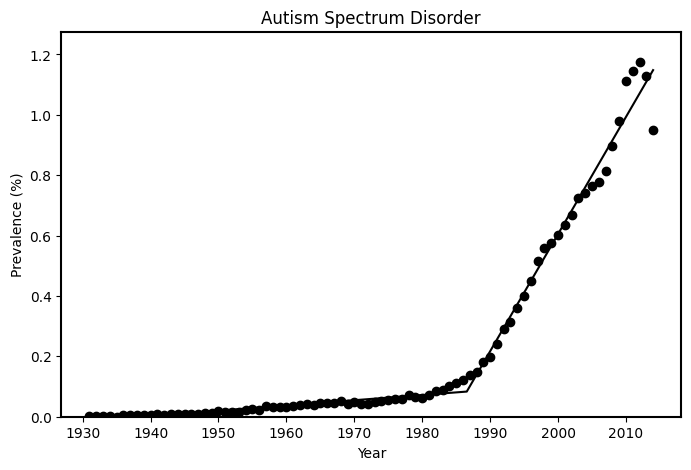

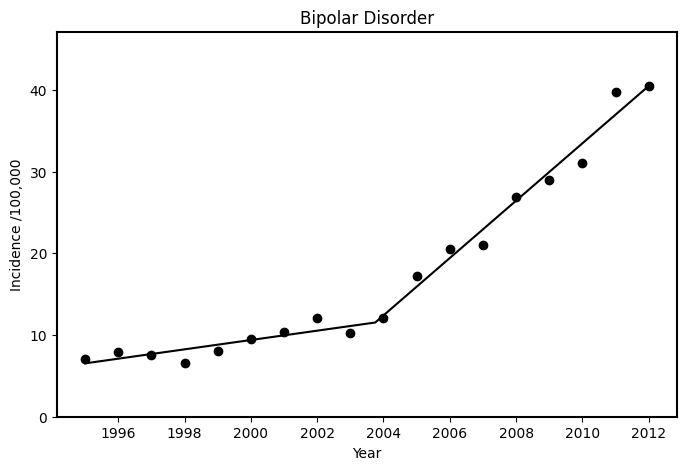

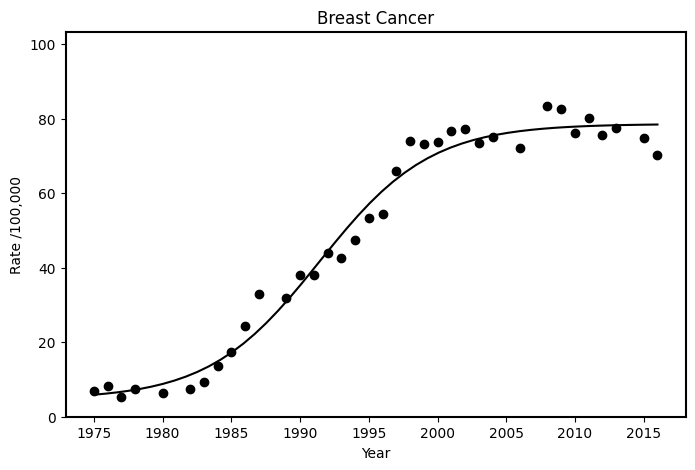

Min year: 1950
Max year: 2000 

Min Inc/Prev: 0.100
Max Inc/Prev: 9.100 

H_min: 0.080
H_max: 9.042
Celiac Disease H^2: 0.009

Min year: 1976
Max year: 2012 

Min Inc/Prev: 1.727
Max Inc/Prev: 29.627 

Cervical Cancer H^2: 0.058



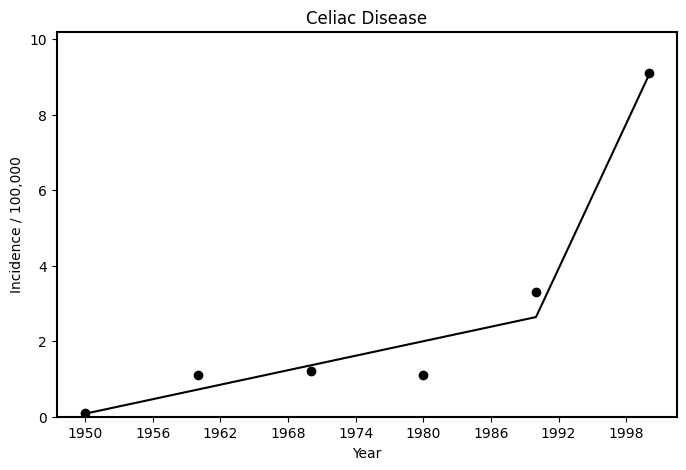

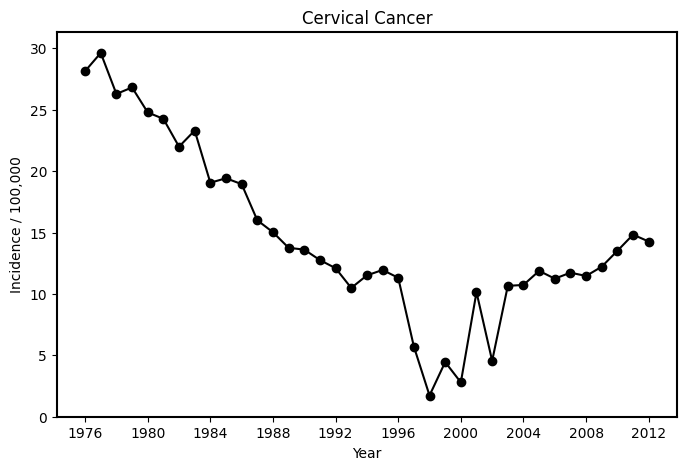

Min year: 1973
Max year: 2005 

Min Inc/Prev: 3.362
Max Inc/Prev: 28.818 

Equation: 0.828x + -1633.508 

H_min: 0.763
H_max: 27.269
Esophageal Cancer H^2: 0.028



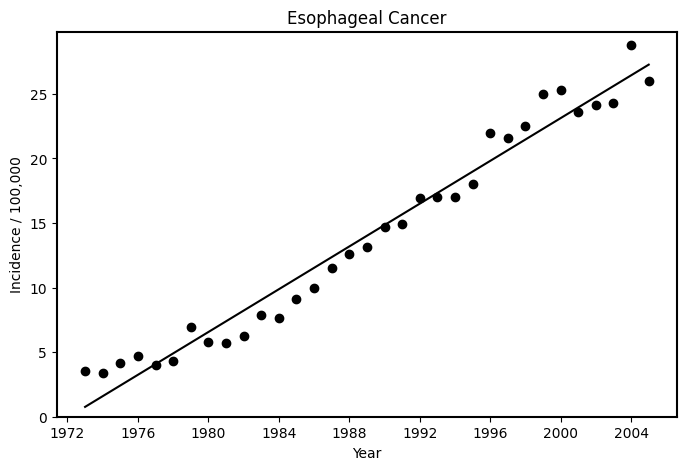

Min year: 1970
Max year: 1996 

Min Inc/Prev: 1.733
Max Inc/Prev: 45.600 

H_min: 1.663
H_max: 46.343
Graves Disease H^2: 0.036

Min year: 1964
Max year: 2014 

Min Inc/Prev: 5.300
Max Inc/Prev: 29.800 

H_min: 5.342
H_max: 29.965
Hay Fever H^2: 0.178

Min year: 1961
Max year: 2002 

Min Inc/Prev: 2.800
Max Inc/Prev: 25.200 

Hypercholesteremia H^2: 0.111



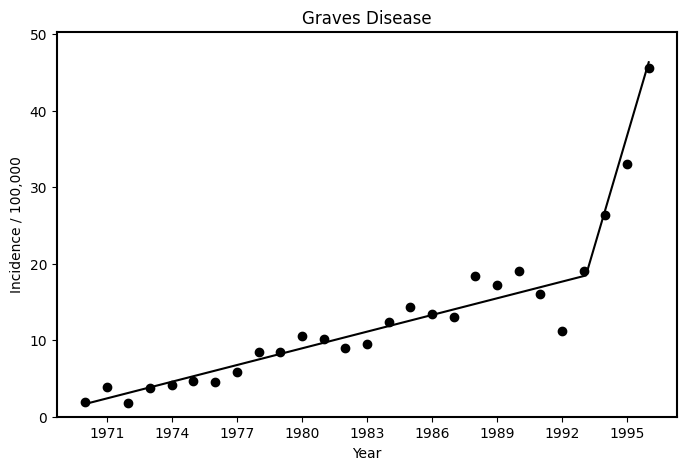

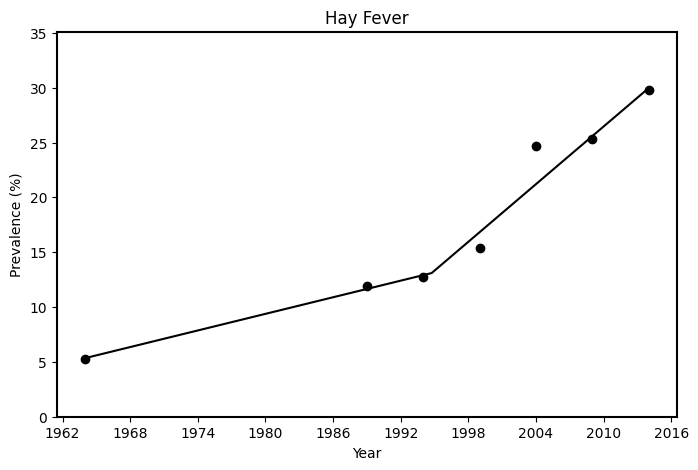

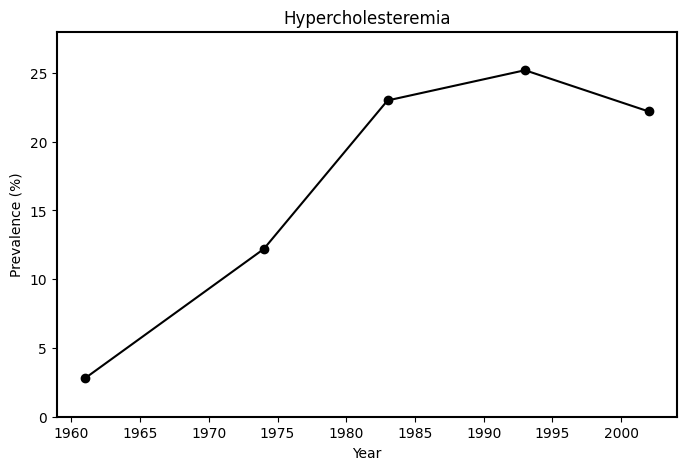

Min year: 1918
Max year: 1973 

Min Inc/Prev: 6.669
Max Inc/Prev: 187.374 

Equation: 180.191 / (1 + e^(-1947.062*(x - 0.213))) + 7.582 

H_min: 7.582
H_max: 187.773
Lung Cancer Mortality H^2: 0.040



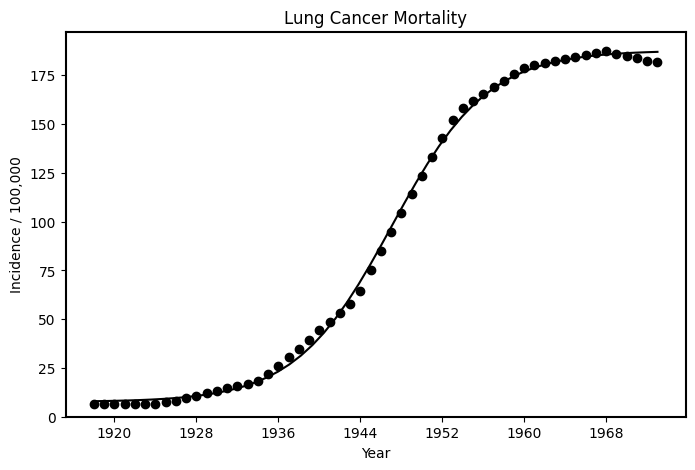

Min year: 1943
Max year: 1995 

Min Inc/Prev: 9.480
Max Inc/Prev: 86.798 

H_min: 10.180
H_max: 85.952
Myopia H^2: 0.118

Min year: 1890
Max year: 2017 

Min Inc/Prev: 3.550
Max Inc/Prev: 46.400 

Equation: 0.296x + -558.297 

H_min: 1.658
H_max: 39.284
Obesity H^2: 0.042



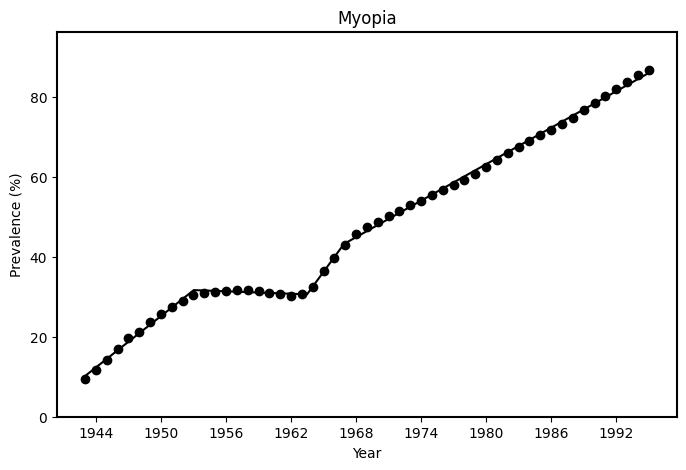

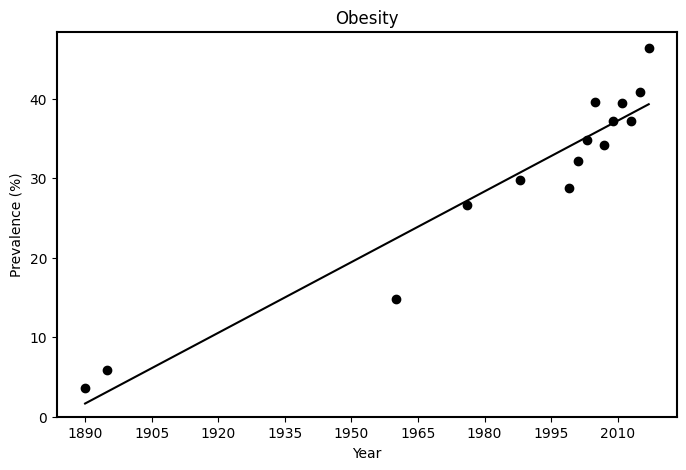

Min year: 1970
Max year: 1999 

Min Inc/Prev: 43.323
Max Inc/Prev: 135.857 

Equation: 2.998x + -5863.937 

H_min: 42.789
H_max: 129.740
Psoriasis H^2: 0.330



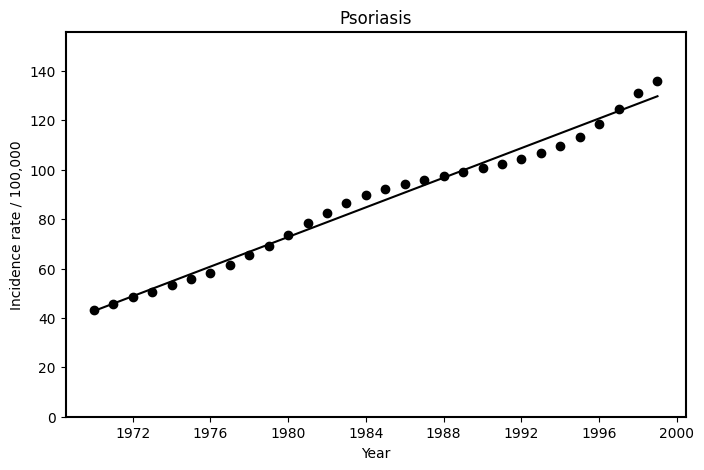

Min year: 1965
Max year: 1985 

Min Inc/Prev: 0.079
Max Inc/Prev: 0.391 

Equation: -0.016x + 31.081 

H_min: 0.081
H_max: 0.394
Rheumatoid Arthritis H^2: 0.206



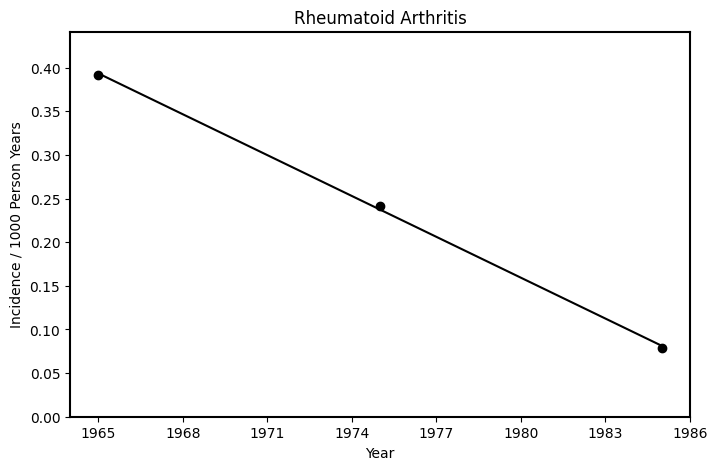

Min year: 1900
Max year: 1995 

Min Inc/Prev: 27.531
Max Inc/Prev: 134.463 

Equation: -1.146x + 2316.970 

H_min: 31.002
H_max: 139.857
Stroke H^2: 0.222



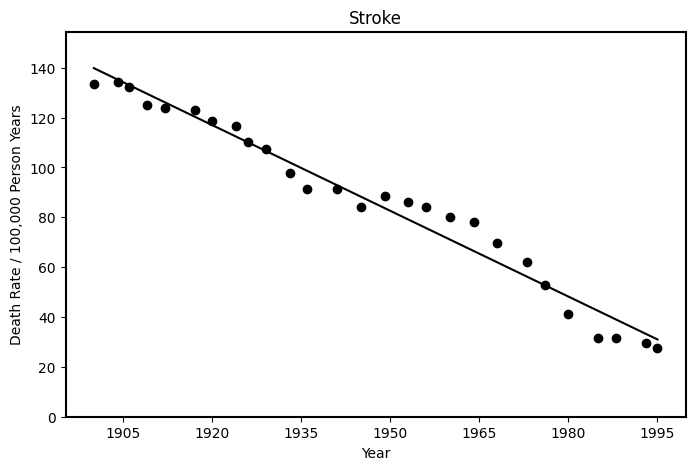

Min year: 1970
Max year: 2006 

Min Inc/Prev: 1.815
Max Inc/Prev: 21.606 

H_min: 2.601
H_max: 19.072
Type I Diabetes H^2: 0.136

maximum iteration reached
Min year: 1958
Max year: 2019 

Min Inc/Prev: 0.870
Max Inc/Prev: 11.300 

H_min: 0.961
H_max: 11.300
Type II Diabetes H^2: 0.085

maximum iteration reached
maximum iteration reached
Min year: 1940
Max year: 1984 

Min Inc/Prev: 0.647
Max Inc/Prev: 9.394 

Ulcerative Colitis H^2: 0.069



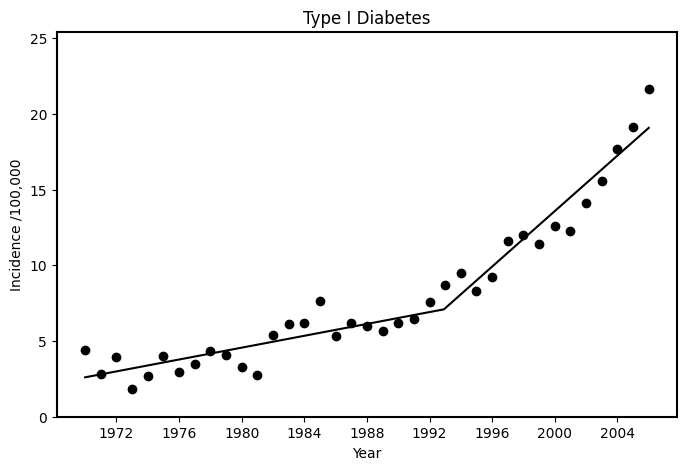

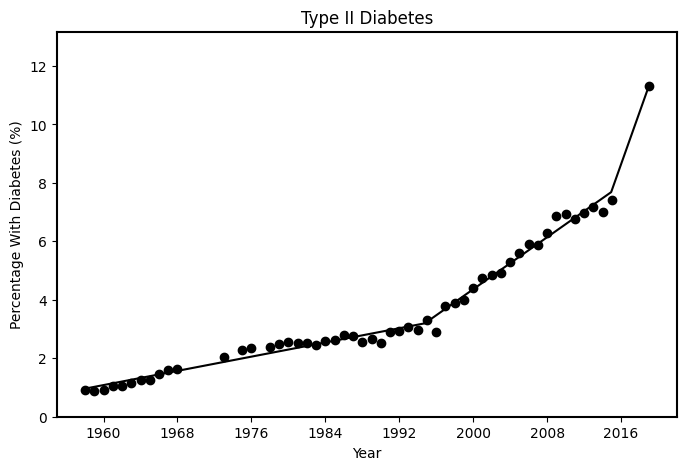

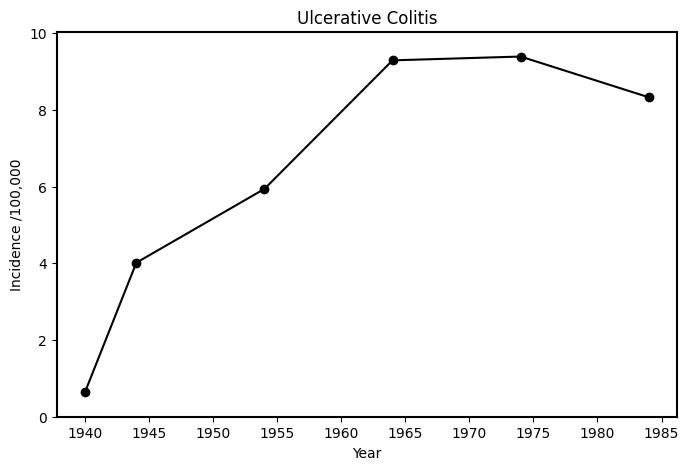

In [59]:
# --- Alzheimer's Disease
eqn = scatter("alzheimers", "Alzheimer's Disease", "Prevalence (%)", 0.5)

# --- Anorexia Nervosa
eqn = fit_line("anorexia2", "Anorexia Nervosa", "Incidence /100,000", 5)
#fit_sigmoid("anorexia", "Anorexia Nervosa", "Incidence /100,000", 0.5) # This data not used in manuscript table 4 but referenced in supporting information

# --- Asthma
eqn = fit_segmented("asthma_2", "Asthma", "Prevalence (%)", 0, [1990])

# --- Atopic Dermatitis
eqn = fit_segmented("atopic_dermatitis", "Atopic Dermatitis", "Prevalence (%)", 0, [1990])

# --- Austism
eqn = fit_segmented("autism", "Autism Spectrum Disorder", "Prevalence (%)", 0.1, [1990])

# --- Bipolar disorder
eqn = fit_segmented("bpd", "Bipolar Disorder", "Incidence /100,000", 0, [2003])

# --- Breast cancer
#eqn = minmax_time("raw_breast_cancer", "Breast Cancer", "Incidence / 100000", "Country", 0) # Do NOT use - keep for geographic
fit_sigmoid("brC", "Breast Cancer", "Rate /100,000", 20)

# --- Celiac disease
eqn = fit_segmented("celiac_dz", "Celiac Disease", "Incidence / 100,000", 1, [1990])

# --- Cervical cancer
eqn = scatter("cervical_cancer", "Cervical Cancer", "Incidence / 100,000", 0)

# --- Esophageal cancer
eqn = fit_line("esophageal_carcinoma", "Esophageal Cancer", "Incidence / 100,000", 1)

# --- Graves disease
eqn = fit_segmented("graves_disease", "Graves Disease", "Incidence / 100,000", 3, [1987])

# --- Hay fever
eqn = fit_segmented("raw_hay_fever", "Hay Fever", "Prevalence (%)", 0, [1989])

# --- Hypercholesteremia
eqn = scatter("hyperchol", "Hypercholesteremia", "Prevalence (%)", 0)

# --- Lung cancer # NEED TO FIND DATA!!!!
eqn = fit_sigmoid("lung_cancer", "Lung Cancer Mortality", "Incidence / 100,000", 10)

# --- Myopia
eqn = fit_segmented("myopia_hk", "Myopia", "Prevalence (%)", 0, [1959,1963,1966])

# --- Obesity
eqn = fit_line("obesity", "Obesity", "Prevalence (%)", 2)

# --- Psoriasis
eqn = fit_line("psoriasis_1", "Psoriasis", "Incidence rate / 100,000", 20)

# --- Rheumatoid arthritis
eqn = fit_line("rheum_arth", "Rheumatoid Arthritis", "Incidence / 1000 Person Years", 0.05)

# --- Stroke
eqn = fit_line("stroke", "Stroke", "Death Rate / 100,000 Person Years", 20)

# --- Type I diabetes
eqn = fit_segmented("type_I_diabetes_2", "Type I Diabetes", "Incidence /100,000", 2, [1985])

# --- Type II diabetes
eqn = fit_segmented("DM2", "Type II Diabetes", "Percentage With Diabetes (%)", 1, [1994,2015])

# --- Ulcerative colitis
eqn = scatter("ulcertative_colitis", "Ulcerative Colitis", "Incidence /100,000", 0)

## Table 5: Quantitative

Min year: 1830
Max year: 1960 

Min Inc/Prev: 13.01386
Max Inc/Prev: 16.18707 

Standard Deviation: 0.98 

G = 1 - E = 1 - 0.80949 

Age at Menarche H^2: 0.19051



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

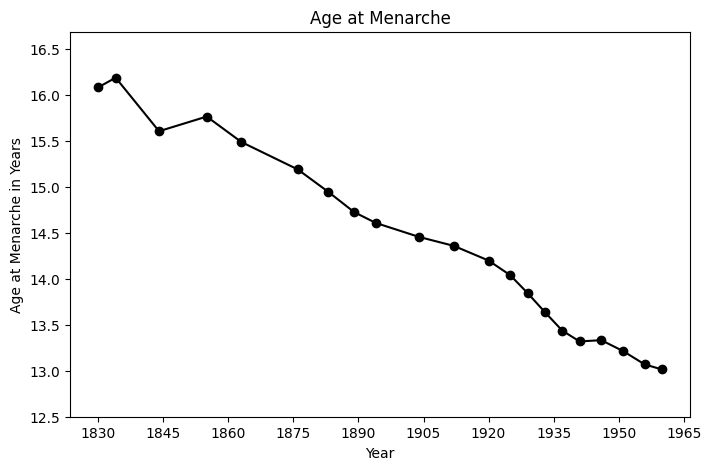

Min year: 1979
Max year: 2007 

Min Inc/Prev: 78.00000
Max Inc/Prev: 83.80000 

Standard Deviation: 1.98 

G = 1 - E = 1 - 0.73371 

Diastolic Blood Pressure (DBP) H^2: 0.26629



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

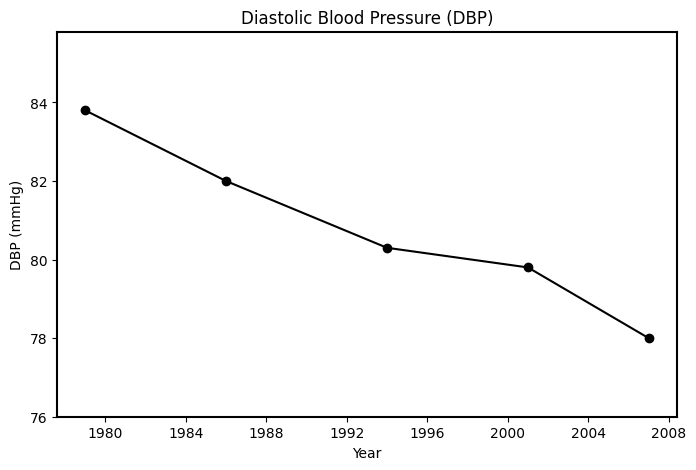

Min year: 1979
Max year: 2007 

Min Inc/Prev: 118.70000
Max Inc/Prev: 129.30000 

Standard Deviation: 3.88 

G = 1 - E = 1 - 0.68265 

Systolic Blood Pressure (SBP) H^2: 0.31735



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

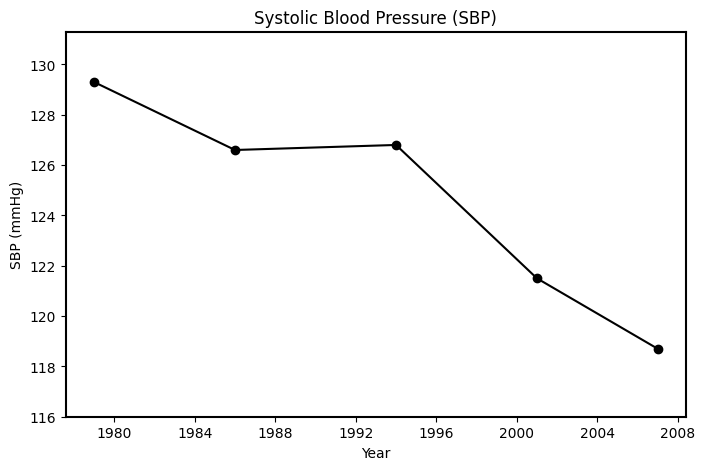

Min year: 1882
Max year: 1986 

Min Inc/Prev: 22.59567
Max Inc/Prev: 31.46209 

Standard Deviation: 2.50 

G = 1 - E = 1 - 0.88664 

Body Mass Index (BMI) H^2: 0.11336



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

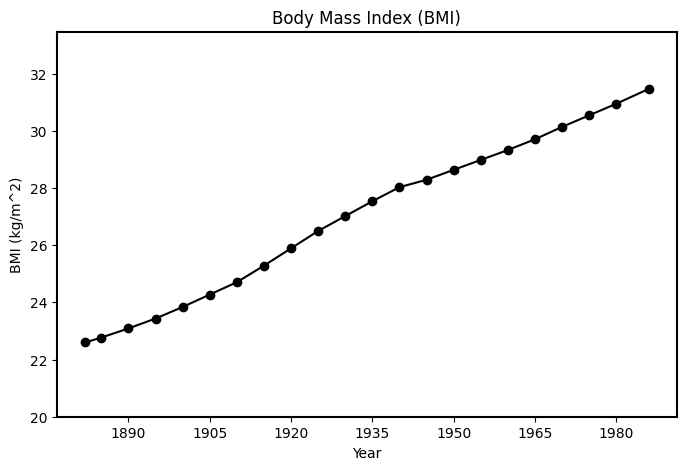

Min year: 1822
Max year: 1997 

Min Inc/Prev: 160.92600
Max Inc/Prev: 183.89800 

Standard Deviation: 7.10 

G = 1 - E = 1 - 0.80887 

Height H^2: 0.19113



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

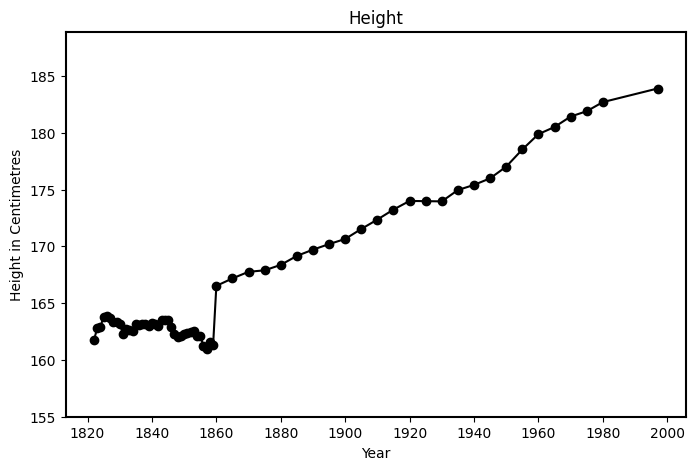

Min year: 1951
Max year: 2013 

Min Inc/Prev: 0.00000
Max Inc/Prev: 36.75000 

Standard Deviation: 15.00 

G = 1 - E = 1 - 0.61250 

Intelligence Quotient (IQ) H^2: 0.38750



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

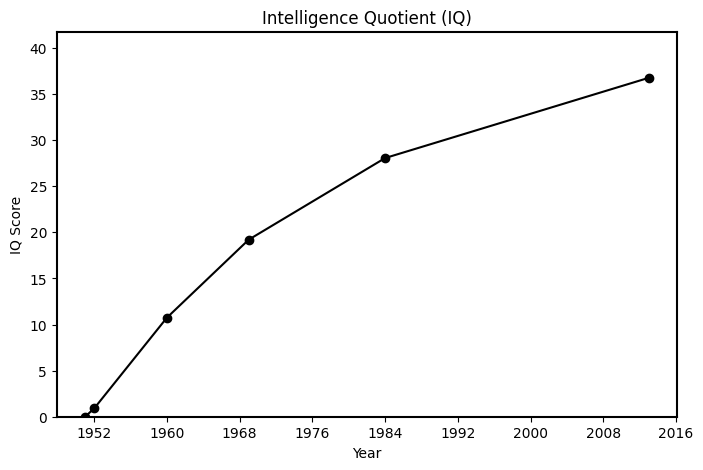

In [8]:
# Standard Deviations to estimate SHEST for quantitative traits.
# Refer to our manuscript for full references.

# NOTE: for SBP and DBP, we used the population means reported in the referenced study to calculate the population standard deviation

AAM_SD = 0.98     # Thomas et. al, 2001. International Variability of Ages at Menarche and Menopause: Patterns and Main Determinants
DBP_SD = None     # Hopstock, 2015. Longitudinal and Secular Trends in Blood Pressure Among Women and Men in Birth Cohorts Born Between 1905 and 1977 The Tromsø Study 1979 to 2008
SBP_SD = None     # Hopstock, 2015. Longitudinal and Secular Trends in Blood Pressure Among Women and Men in Birth Cohorts Born Between 1905 and 1977 The Tromsø Study 1979 to 2008
BMI_SD = 2.5      # Floud, 1998. Height, Weight and Body Mass of the British Population Since 1820
Height_SD = 7.1   # Schonbeck et. al, 2012. The world’s tallest nation has stopped growing taller: the height of Dutch children from 1955 to 2009
IQ_SD = 15.0      # Trahan et. al, 2014. The Flynn Effect: A Meta-analysis

# AAM
scatter_quantitative("aam", "Age at Menarche", "Age at Menarche in Years", 0.5, AAM_SD, 12.5)

# DBP
scatter_quantitative("diasBPwomen", "Diastolic Blood Pressure (DBP)", "DBP (mmHg)", 2, DBP_SD, 76)

# SBP
scatter_quantitative("systolicBPwomen", "Systolic Blood Pressure (SBP)", "SBP (mmHg)", 2, SBP_SD, 116)

# BMI
scatter_quantitative("bmi", "Body Mass Index (BMI)", "BMI (kg/m^2)", 2, BMI_SD, 20)

# Height
scatter_quantitative("height", "Height", "Height in Centimetres", 5, Height_SD, 155)

# IQ
scatter_quantitative("iq", "Intelligence Quotient (IQ)", "IQ Score", 5, IQ_SD, 0)

## Counter Examples

Min year: 1975
Max year: 2017 

Min Inc/Prev: 5.312
Max Inc/Prev: 109.003 

Beta thalassemia H^2: 0.049



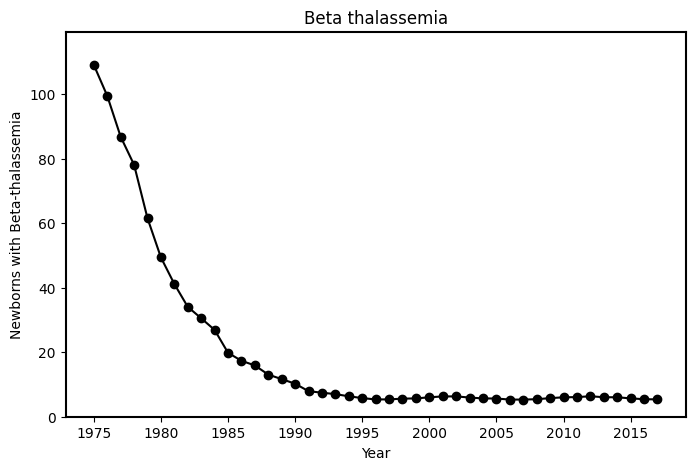

Min year: 1995
Max year: 2017 

Min Inc/Prev: 5.312
Max Inc/Prev: 6.340 

Equation: 0.004x + -1.311 

H_min: 5.721
H_max: 5.798
Beta thalassemia H^2: 0.987



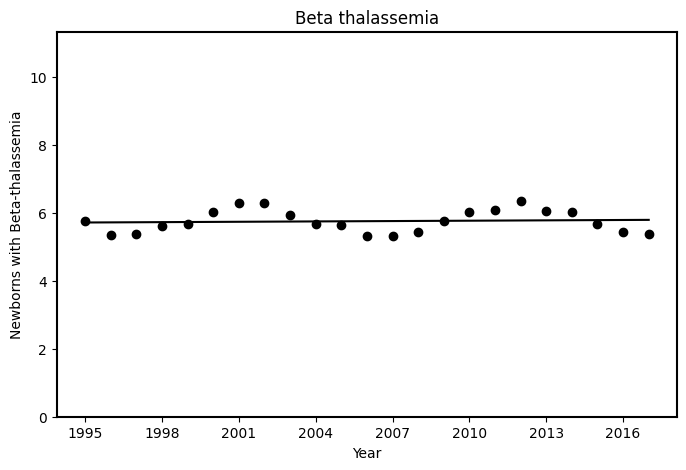

In [41]:
# Beta-thalassemia
eqn = scatter("beta_thal", "Beta thalassemia", "Newborns with Beta-thalassemia", 5)
eqn = fit_line("beta_thal_lin", "Beta thalassemia", "Newborns with Beta-thalassemia", 5)


Min year: 1951
Max year: 1981 

Min Inc/Prev: 0.445
Max Inc/Prev: 1.317 

H_min: 0.470
H_max: 1.289
Hereditary Haemochromatosis H^2: 0.365

Min year: 1951
Max year: 1971 

Min Inc/Prev: 0.445
Max Inc/Prev: 0.540 

Equation: 0.001x + -2.223 

H_min: 0.470
H_max: 0.497
Hereditary Heamochromatosis H^2: 0.945



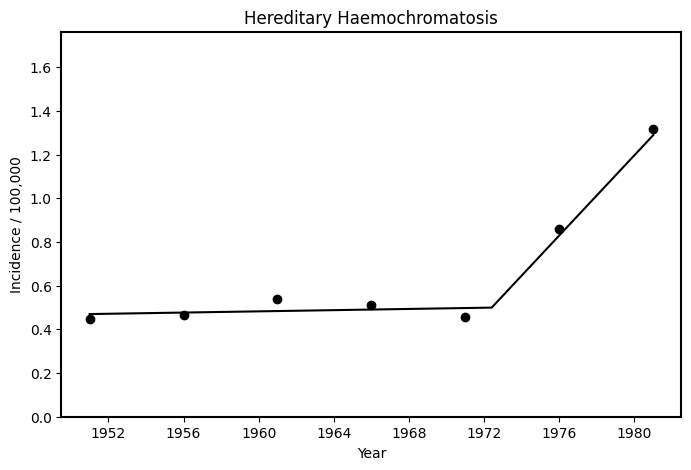

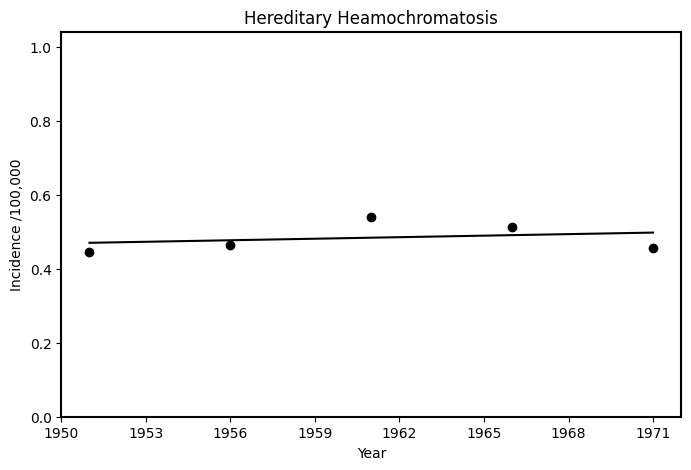

In [45]:
# Hereditary haemochromatosis
eqn = fit_segmented("Hereditary_Heam", "Hereditary Haemochromatosis", "Incidence / 100,000", 0, [1965])
eqn = fit_line("g_Hereditary_Heam", "Hereditary Heamochromatosis", "Incidence /100,000", 0.5)

Min year: 1992
Max year: 2015 

Min Inc/Prev: 2392.102
Max Inc/Prev: 3232.066 

Equation: -19.902x + 42617.608 

H_min: 2514.929
H_max: 2972.676
Human Immunodeficiency Virus H^2: 0.846



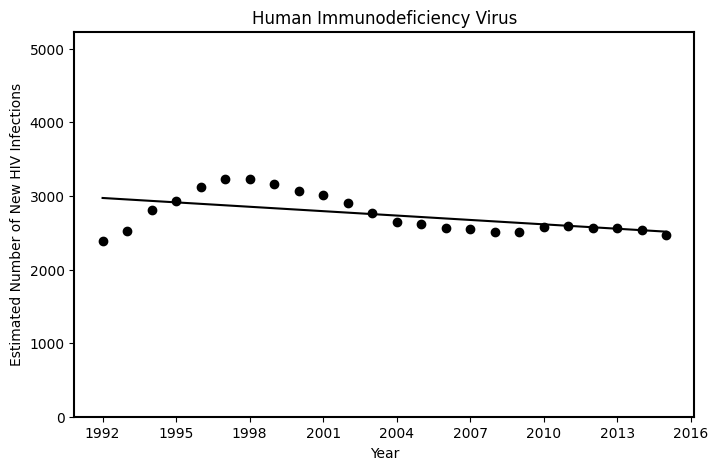

Min year: 1980
Max year: 2015 

Min Inc/Prev: 150.607
Max Inc/Prev: 3232.066 

H_min: 117.657
H_max: 3161.424
Human Immunodeficiency Virus H^2: 0.037



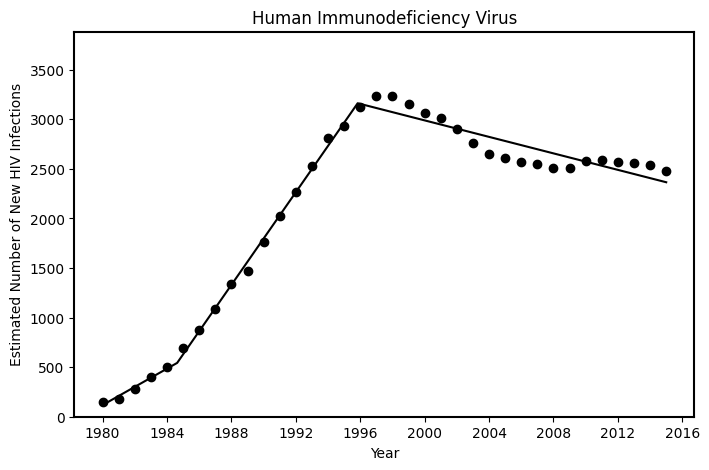

In [52]:
# HIV
eqn = fit_line("HIV_1992to2015", "Human Immunodeficiency Virus", "Estimated Number of New HIV Infections", 2000)
eqn = fit_segmented("HIV", "Human Immunodeficiency Virus", "Estimated Number of New HIV Infections", 500, [1980,1998])

Min year: 1930
Max year: 1980 

Min Inc/Prev: 17.292
Max Inc/Prev: 28.921 

Equation: -0.025x + 72.156 

H_min: 22.378
H_max: 23.635
Motor Vehicle Deaths (1930 - 1980) H^2: 0.947



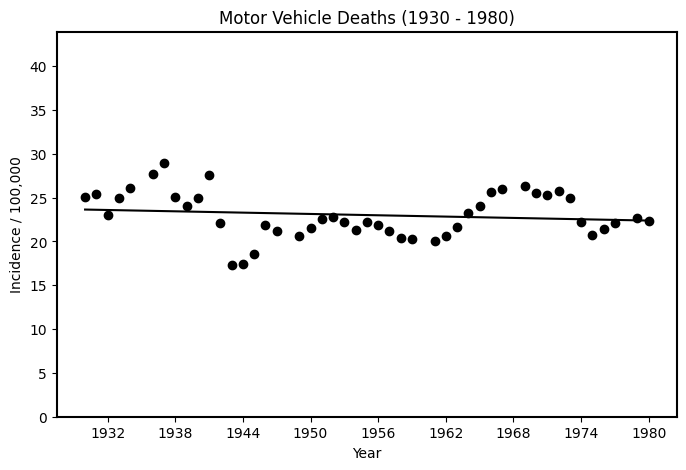

Min year: 1900
Max year: 2012 

Min Inc/Prev: 0.000
Max Inc/Prev: 28.921 

H_min: 0.000
H_max: 29.264
Motor Vehicle Deaths (1900 - 2010) H^2: 0.000



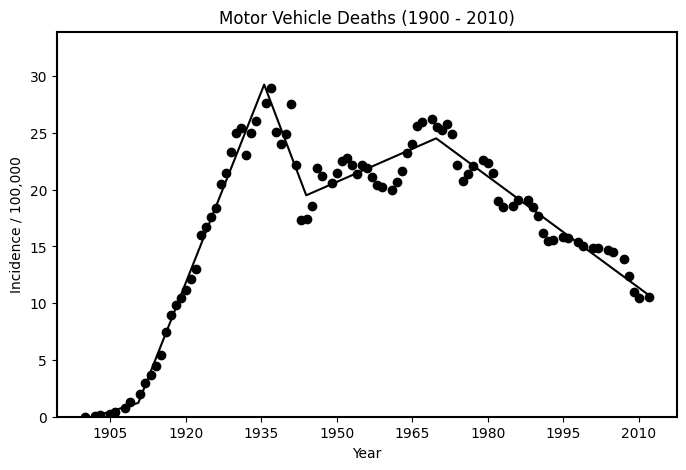

In [47]:
# Motor vehicle deaths in the USA
eqn = fit_line("motor_deaths_1930to1980", "Motor Vehicle Deaths (1930 - 1980)", "Incidence / 100,000", 15)
eqn = fit_segmented("motor_deaths", "Motor Vehicle Deaths (1900 - 2010)", "Incidence / 100,000", 5, [1905,1915,1958,1970])

Min year: 1979
Max year: 1986 

Min Inc/Prev: 26.147
Max Inc/Prev: 29.421 

Equation: 0.287x + -540.610 

H_min: 26.986
H_max: 28.994
Ocular Trauma H^2: 0.931



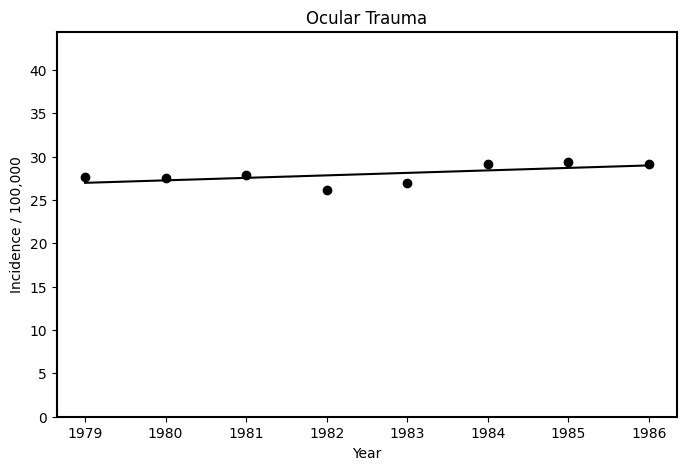

In [48]:
# Ocular Trauma
eqn = fit_line("ocular_trauma", "Ocular Trauma", "Incidence / 100,000", 15)